In [62]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from tqdm import tqdm
import torchvision

In [63]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
train_size = int(0.9 * len(trainset))
valid_size = int(0.1 * len(trainset))
_,validset = torch.utils.data.random_split(trainset, [train_size, valid_size])


train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(
    validset, batch_size = 100, shuffle = False, num_workers = 2
)


testset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [65]:
for (X_train, Y_train) in train_loader:
    print(f"X_train: {X_train.size()} type: {X_train.type()}")
    print(f"Y_train: {Y_train.size()} type: {Y_train.type()}")
    break

X_train: torch.Size([128, 3, 32, 32]) type: torch.FloatTensor
Y_train: torch.Size([128]) type: torch.LongTensor


In [66]:
def make_layer(config):
    layers = []
    in_planes = 3
    for value in config:
        if value == "M":
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        else:
            layers.append(nn.Conv2d(in_planes, value, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            in_planes = value
    return nn.Sequential(*layers)

In [67]:
class VGG(nn.Module):
    def __init__(self, config, num_classes=10):
        super(VGG, self).__init__()
        self.features = make_layer(config)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, num_classes)  
        ) 
        
    def forward(self, x):
        out = self.features(x)
        out = torch.flatten(out,1)
        out = self.classifier(out)
        return out

In [68]:
#cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
#vgg16
cfg =  [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
#vgg19
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"Using PyTorch version: {torch.__version__}, Device: {DEVICE}")

model = VGG(cfg).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


Using PyTorch version: 1.13.1+cu116, Device: cuda


https://blogofth-lee.tistory.com/265

In [70]:
def train(model, train_loader, optimizer, bar):
    model.train()
    total_loss = 0
    total_cnt = 0
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_cnt += image.shape[0]
    return total_loss / total_cnt

In [71]:
def evaluate(model, test_loader, train_loader):
    model.eval()
    test_correct = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            prediction = output.max(1, keepdim=True)[1]
            test_correct += prediction.eq(label.view_as(prediction)).sum().item()
    train_correct = 0
    with torch.no_grad():
        for image, label in train_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            prediction = output.max(1, keepdim=True)[1]
            train_correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_accuracy = 100. * test_correct / len(test_loader.dataset)
    train_accuracy = 100. * train_correct / len(train_loader.dataset)
    return test_accuracy, train_accuracy

In [72]:
EPOCHS = 200
train_loss_save = []
test_loss_save = []
train_acc_save = []
test_acc_save = []
bar = tqdm(range(1, EPOCHS + 1), total=EPOCHS, desc='Train ')
for Epoch in bar:
    train_loss = train(model, train_loader, optimizer, bar)
    test_accuracy, train_accuracy = evaluate(model, test_loader, train_loader)
    scheduler.step()
    bar.set_postfix(
            test_accuracy=f"{test_accuracy:0.3f}",
            train_loss=f"{train_loss:0.3f}",
            train_accuracy=f"{train_accuracy:0.3f}",
        )
    train_acc_save.append(train_accuracy)
    train_loss_save.append(train_loss)
    test_acc_save.append(test_accuracy)

Train : 100%|██████████| 200/200 [2:13:12<00:00, 39.96s/it, test_accuracy=89.060, train_accuracy=97.270, train_loss=0.001]  


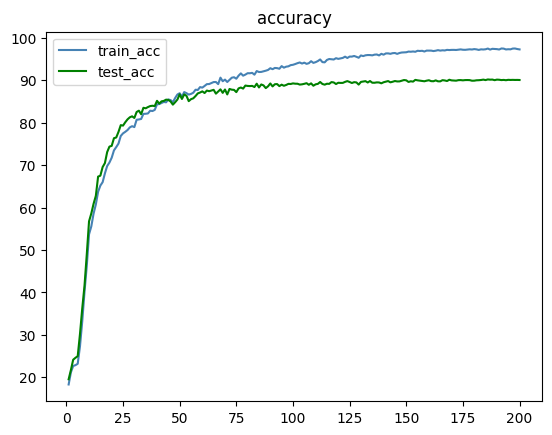

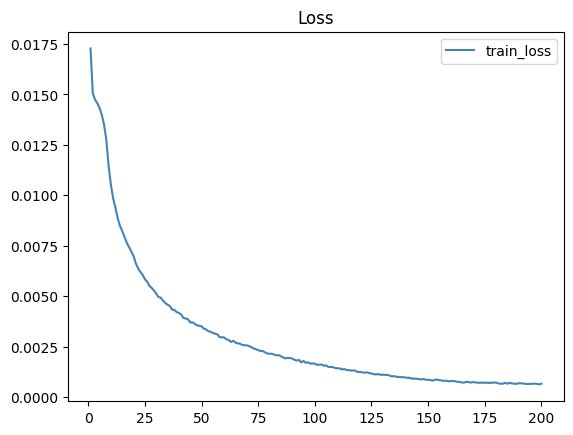

In [79]:
from matplotlib import pyplot as plt
x = [i for i in range (1, EPOCHS+ 1)]


plt.plot(x, train_acc_save, color='steelblue', label = 'train_acc')
plt.plot(x, test_acc_save, color='green', label = 'test_acc')
plt.title('accuracy')
plt.legend()
plt.savefig('./result/result_VGG16_aug_accuracy.png')
plt.show()
# Second Subplot
plt.plot(x, train_loss_save, color='steelblue', label = 'train_loss')
plt.legend()
plt.title('Loss')
plt.savefig('./result/result_VGG16_aug_loss.png')

In [80]:
PATH = './VGG_aug.pt'
torch.save(model.state_dict(), PATH)

In [81]:
print("train_set : " + str(train_acc_save[-1]))
print("test_set : " + str(test_acc_save[-1]))


train_set : 97.27
test_set : 90.06
